# CNN activations
This is a development notebook used for computing and analyzing the activations of a convolutional neural network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import umap
from openTSNE import TSNE
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng

import json
import importlib
from copy import deepcopy

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/rumaak/Dropbox/College/BP_RP/neural_networks_internal_representations/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
rng = default_rng()

### Data

Loading MNIST and FashionMNIST datasets.

In [4]:
from src.dataset_loading import load_MNIST, load_FashionMNIST

Some properties of the MNIST dataset:

In [5]:
training_data, test_data = load_MNIST()

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [7]:
print(training_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Number of classes: {len(training_data.classes)}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Number of classes: 10


Some properties of the FashionMNIST dataset:

In [9]:
training_data, test_data = load_FashionMNIST()

In [10]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [11]:
print(training_data)
print(test_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Number of classes: {len(training_data.classes)}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Number of classes: 10


We can see that both datasets consist of 60 000 training and 10 000 test examples. Each image of either dataset has only a single channel and its dimensions are 28x28. Each example is associated with one of ten labels.

In [13]:
width, height = 28, 28
n_classes = 10
n_examples = 60_000

### Model
The model we are going to be working with.

In [14]:
from src.activations_cnn.network import NeuralNetwork

### Training
Methods used for training of the network.

In [15]:
from src.activations_cnn.training import train_loop, test_loop

### Analysis
Analysis of the neural network activations.

In [16]:
from src.activations_cnn.metrics import same_diff_average, knn_evaluate, dist_between_centroids, dist_to_centroid

In [17]:
from src.activations_cnn.analysis import get_activations_labels, single_embedding_metrics, analyze_outliers, analyze_filters

In [18]:
from src.activations_cnn.embedding import activations_tsne_plot_save, activations_umap_plot_save

### MNIST

In [19]:
# Load data
training_data, test_data = load_MNIST()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [20]:
# Initialize network
network = NeuralNetwork(n_classes)
network.to(device)

# Save untrained copy of the network
untrained_state = deepcopy(network.state_dict())
untrained_network = NeuralNetwork(n_classes)
untrained_network.to(device).load_state_dict(untrained_state)

<All keys matched successfully>

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=1e-2, momentum=0.9)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, network, loss_fn, optimizer, device)
    test_loop(test_dataloader, network, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304328  [    0/60000]
loss: 2.153396  [ 6400/60000]
loss: 0.587635  [12800/60000]
loss: 0.349380  [19200/60000]
loss: 0.473319  [25600/60000]
loss: 0.157451  [32000/60000]
loss: 0.278277  [38400/60000]
loss: 0.204452  [44800/60000]
loss: 0.063766  [51200/60000]
loss: 0.118223  [57600/60000]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.103678 

Epoch 2
-------------------------------
loss: 0.076191  [    0/60000]
loss: 0.117068  [ 6400/60000]
loss: 0.037590  [12800/60000]
loss: 0.048534  [19200/60000]
loss: 0.242075  [25600/60000]
loss: 0.054247  [32000/60000]
loss: 0.040252  [38400/60000]
loss: 0.018279  [44800/60000]
loss: 0.020248  [51200/60000]
loss: 0.108699  [57600/60000]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.067349 

Epoch 3
-------------------------------
loss: 0.096726  [    0/60000]
loss: 0.156895  [ 6400/60000]
loss: 0.122901  [12800/60000]
loss: 0.103222  [19200/60000]
loss: 0.057355  [25600/60000]
loss: 0.055459  [32000/600

In [22]:
# We won't need the data to be shuffled anymore
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [23]:
# Saving activations over the whole dataset for individual layers 
# (and corresponding filters)
activations_zero, activations_first, activations_second, activations_third, labels = get_activations_labels(
    n_examples,
    width,
    height,
    train_dataloader,
    network,
    device
)

In [24]:
# Take smaller subset of data

labels = labels[:5_000]
activations_zero = activations_zero[:5000]

for i in range(4):
    activations_first[i] = activations_first[i][:5000]
    
for i in range(16):
    activations_second[i] = activations_second[i][:5000]

activations_third = activations_third[:5000]

In [25]:
# --------- activations from network extracted -------- 

In [26]:
# Computing embeddings for one of the layers (filters)

In [27]:
%%time

embeddings = activations_tsne_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/mnist/t-sne/trained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 22min 40s, sys: 21.1 s, total: 23min 1s
Wall time: 3min 13s


In [28]:
# Metrics of embedding quality (same as before)

In [29]:
def update_results(results, embeddings, dataset_name, network_type, labels, training_data):
    e0, e1, e2, e3 = embeddings 
    
    results[0][(dataset_name, network_type)] = [(single_embedding_metrics(e0, labels, training_data))]
    
    results[1][(dataset_name, network_type)] = []
    for e in e1:
        results[1][(dataset_name, network_type)].append(single_embedding_metrics(e, labels, training_data))
        
    results[2][(dataset_name, network_type)] = []
    for e in e2:
        results[2][(dataset_name, network_type)].append(single_embedding_metrics(e, labels, training_data))
        
    results[3][(dataset_name, network_type)] = [(single_embedding_metrics(e3, labels, training_data))]

In [30]:
results = {
    0: dict(),
    1: dict(),
    2: dict(),
    3: dict()
}
update_results(results, embeddings, "t-sne", "trained", labels, training_data)

In [31]:
def stringify_results(results):
    new_results = dict()
    for key1 in results:
        new_results[key1] = dict()
        result = results[key1]
        for key2 in result:
            new_results[key1][str(key2)] = result[key2]
            
    return new_results

In [32]:
# ------- results (metrics) computed and saved into `results` ----------

In [33]:
# Analysis of the third layer

In [34]:
e0, e1, e2, e3 = embeddings 

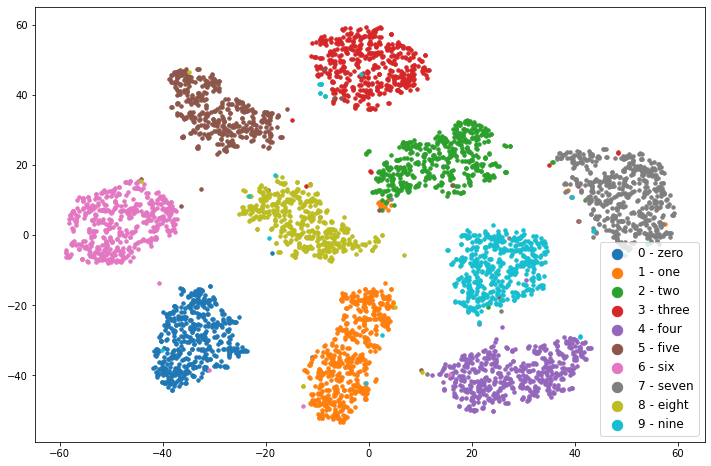

In [35]:
# NOTE: no need to create new plot - already exists
fig, axes = plt.subplots(figsize=(12,8))

for i,actual_label in enumerate(training_data.classes):
    indices = np.argwhere(labels == i)
    indices = np.squeeze(indices)

    axes.scatter(e3[indices,0],e3[indices,1],label=actual_label,s=12)
    axes.legend(markerscale=3, fontsize=12)

In [36]:
%%time

analyze_outliers(training_data, e3, labels, "../out/activations_cnn/mnist/t-sne/outliers/")

CPU times: user 22.7 s, sys: 119 ms, total: 22.8 s
Wall time: 16.6 s


In [37]:
# Per filter analysis

In [38]:
%%time

analyze_filters(training_data, "../out/activations_cnn/mnist/t-sne/filter_outputs/", network, rng, device)

CPU times: user 10 s, sys: 43.2 ms, total: 10.1 s
Wall time: 9.6 s


In [39]:
# UMAP

In [40]:
%%time

e0, e1, e2, e3 = activations_umap_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/mnist/umap/trained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 7min 29s, sys: 20.3 s, total: 7min 50s
Wall time: 2min 8s


In [41]:
update_results(results, embeddings, "umap", "trained", labels, training_data)

In [42]:
# TODO same for the untrained network

In [43]:
# Saving activations over the whole dataset for individual layers 
# (and corresponding filters)
activations_zero, activations_first, activations_second, activations_third, labels = get_activations_labels(
    n_examples,
    width,
    height,
    train_dataloader,
    untrained_network,
    device
)

In [44]:
# Take smaller subset of data

labels = labels[:5_000]
activations_zero = activations_zero[:5000]

for i in range(4):
    activations_first[i] = activations_first[i][:5000]
    
for i in range(16):
    activations_second[i] = activations_second[i][:5000]

activations_third = activations_third[:5000]

In [45]:
# --------- activations from network extracted -------- 

In [46]:
# Computing embeddings for one of the layers (filters)

In [47]:
%%time

embeddings = activations_tsne_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/mnist/t-sne/untrained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 23min 4s, sys: 17.1 s, total: 23min 21s
Wall time: 3min 15s


In [48]:
# Metrics of embedding quality (same as before)

In [49]:
update_results(results, embeddings, "t-sne", "untrained", labels, training_data)

In [50]:
# ------- results (metrics) computed and saved into `results` ----------

In [51]:
# UMAP

In [52]:
%%time

e0, e1, e2, e3 = activations_umap_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/mnist/umap/untrained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 8min 20s, sys: 20.3 s, total: 8min 40s
Wall time: 2min 5s


In [53]:
update_results(results, embeddings, "umap", "untrained", labels, training_data)

In [54]:
def save_dataframe(df, out_dir, name):
    with open(out_dir+name+'.tex', 'w') as tf:
        tf.write(df.to_latex())

    with open(out_dir+name+'.csv', 'w') as tf:
        tf.write(df.to_csv())

In [55]:
def save(results, output_dir):
    for layer in range(4):
        layer_result = results[layer]
        
        for method in ["t-sne", "umap"]:
            trained_df = pd.DataFrame(layer_result[method, "trained"])
            untrained_df = pd.DataFrame(layer_result[method, "untrained"])

            result_df = pd.DataFrame()
            result_df["ds"] = trained_df["ds"] + " / " + untrained_df["ds"]
            result_df["dd"] = trained_df["dd"] + " / " + untrained_df["dd"]
            result_df["cs"] = trained_df["cs"] + " / " + untrained_df["cs"]
            result_df["cd"] = trained_df["cd"] + " / " + untrained_df["cd"]
            result_df["acc_knn"] = trained_df["acc_knn"] + " / " + untrained_df["acc_knn"]

            row_names = ["filter " + str(i+1) for i in range(len(trained_df))]
            result_df = result_df.rename(dict(zip(result_df.index, row_names)))

            output_dir_path = output_dir + "/" + method + "/"
            save_dataframe(result_df, output_dir_path, "table_l" + str(layer))

In [56]:
def metrics_plots(results, output_dir, method, name):
    metrics = ["ds", "dd", "cs", "cd", "acc_knn"]
    
    trained_vals = dict()
    untrained_vals = dict()
    for m in metrics:
        trained_vals[m] = []
        untrained_vals[m] = []
        
    for layer in results:
        layer_result = results[layer]
        trained_df = pd.DataFrame(layer_result[method, "trained"]).astype(float)
        untrained_df = pd.DataFrame(layer_result[method, "untrained"]).astype(float)
    
        for m in metrics:
            trained_vals[m].append(np.average(trained_df[m]))
            untrained_vals[m].append(np.average(untrained_df[m]))
            
    for m in metrics:
        fig, axes = plt.subplots()
        axes.plot(trained_vals[m], marker=".", label="trained")
        axes.plot(untrained_vals[m], marker=".", label="untrained")
        axes.set(
            xlabel="network depth",
            ylabel=m,
        )
        axes.legend()
        plt.savefig(output_dir + "/" + method + "/" + name + "_" + m + ".png")
        plt.close()

In [57]:
save(results, "../out/activations_cnn/mnist/")

In [58]:
for method in ["t-sne", "umap"]:
    metrics_plots(results, "../out/activations_cnn/mnist/", method, "plot_metric")

### FashionMNIST

In [59]:
# Load data
training_data, test_data = load_FashionMNIST()
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [60]:
# Initialize network
network = NeuralNetwork(n_classes)
network.to(device)

# Save untrained copy of the network
untrained_state = deepcopy(network.state_dict())
untrained_network = NeuralNetwork(n_classes)
untrained_network.to(device).load_state_dict(untrained_state)

<All keys matched successfully>

In [61]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=3e-2, momentum=0.9)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, network, loss_fn, optimizer, device)
    test_loop(test_dataloader, network, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301979  [    0/60000]
loss: 1.877224  [ 6400/60000]
loss: 1.713700  [12800/60000]
loss: 1.098885  [19200/60000]
loss: 1.322365  [25600/60000]
loss: 1.087818  [32000/60000]
loss: 1.102940  [38400/60000]
loss: 0.857388  [44800/60000]
loss: 0.904264  [51200/60000]
loss: 0.797003  [57600/60000]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.911226 

Epoch 2
-------------------------------
loss: 0.853821  [    0/60000]
loss: 0.939883  [ 6400/60000]
loss: 1.108536  [12800/60000]
loss: 0.723025  [19200/60000]
loss: 0.805520  [25600/60000]
loss: 0.926314  [32000/60000]
loss: 1.239688  [38400/60000]
loss: 0.768630  [44800/60000]
loss: 0.652783  [51200/60000]
loss: 0.909597  [57600/60000]
Test Error: 
 Accuracy: 66.3%, Avg loss: 0.839729 

Epoch 3
-------------------------------
loss: 0.754058  [    0/60000]
loss: 0.830923  [ 6400/60000]
loss: 0.767857  [12800/60000]
loss: 0.821163  [19200/60000]
loss: 0.753362  [25600/60000]
loss: 0.903409  [32000/600

In [62]:
# We won't need the data to be shuffled anymore
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [63]:
# Saving activations over the whole dataset for individual layers 
# (and corresponding filters)
activations_zero, activations_first, activations_second, activations_third, labels = get_activations_labels(
    n_examples,
    width,
    height,
    train_dataloader,
    network,
    device
)

In [64]:
# Take smaller subset of data

labels = labels[:5_000]
activations_zero = activations_zero[:5000]

for i in range(4):
    activations_first[i] = activations_first[i][:5000]
    
for i in range(16):
    activations_second[i] = activations_second[i][:5000]

activations_third = activations_third[:5000]

In [65]:
# --------- activations from network extracted -------- 

In [66]:
# Computing embeddings for one of the layers (filters)

In [67]:
%%time

embeddings = activations_tsne_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/fmnist/t-sne/trained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 21min, sys: 14.3 s, total: 21min 14s
Wall time: 2min 53s


In [68]:
# Metrics of embedding quality (same as before)

In [69]:
results = {
    0: dict(),
    1: dict(),
    2: dict(),
    3: dict()
}
update_results(results, embeddings, "t-sne", "trained", labels, training_data)

In [70]:
# ------- results (metrics) computed and saved into `results` ----------

In [71]:
# Analysis of the third layer

In [72]:
e0, e1, e2, e3 = embeddings 

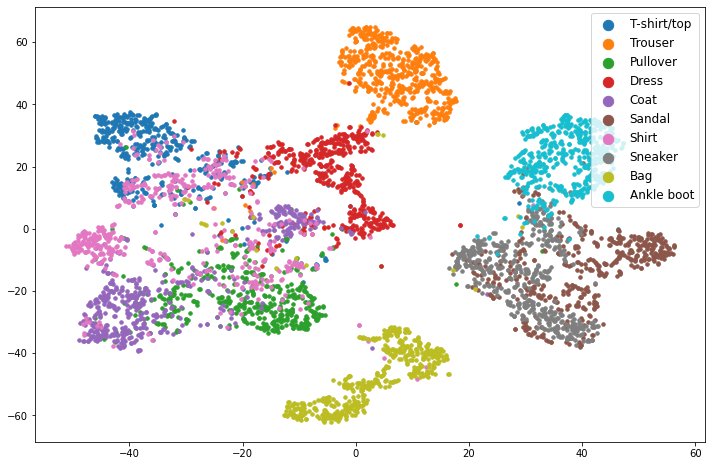

In [73]:
# NOTE: no need to create new plot - already exists
fig, axes = plt.subplots(figsize=(12,8))

for i,actual_label in enumerate(training_data.classes):
    indices = np.argwhere(labels == i)
    indices = np.squeeze(indices)

    axes.scatter(e3[indices,0],e3[indices,1],label=actual_label,s=12)
    axes.legend(markerscale=3, fontsize=12)

In [74]:
%%time

analyze_outliers(training_data, e3, labels, "../out/activations_cnn/fmnist/t-sne/outliers/")

CPU times: user 24.8 s, sys: 72.9 ms, total: 24.9 s
Wall time: 18.4 s


In [75]:
# Per filter analysis

In [76]:
%%time

analyze_filters(training_data, "../out/activations_cnn/fmnist/t-sne/filter_outputs/", network, rng, device)

CPU times: user 10.1 s, sys: 62.7 ms, total: 10.1 s
Wall time: 9.67 s


In [77]:
# UMAP

In [78]:
%%time

e0, e1, e2, e3 = activations_umap_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/fmnist/umap/trained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 8min 15s, sys: 20.7 s, total: 8min 36s
Wall time: 2min


In [79]:
update_results(results, embeddings, "umap", "trained", labels, training_data)

In [80]:
# TODO same for the untrained network

In [81]:
# Saving activations over the whole dataset for individual layers 
# (and corresponding filters)
activations_zero, activations_first, activations_second, activations_third, labels = get_activations_labels(
    n_examples,
    width,
    height,
    train_dataloader,
    untrained_network,
    device
)

In [82]:
# Take smaller subset of data

labels = labels[:5_000]
activations_zero = activations_zero[:5000]

for i in range(4):
    activations_first[i] = activations_first[i][:5000]
    
for i in range(16):
    activations_second[i] = activations_second[i][:5000]

activations_third = activations_third[:5000]

In [83]:
# --------- activations from network extracted -------- 

In [84]:
# Computing embeddings for one of the layers (filters)

In [85]:
%%time

embeddings = activations_tsne_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/fmnist/t-sne/untrained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 20min 29s, sys: 13.3 s, total: 20min 43s
Wall time: 2min 48s


In [86]:
# Metrics of embedding quality (same as before)

In [87]:
update_results(results, embeddings, "t-sne", "untrained", labels, training_data)

In [88]:
# ------- results (metrics) computed and saved into `results` ----------

In [89]:
# UMAP

In [90]:
%%time

e0, e1, e2, e3 = activations_umap_plot_save(activations_zero, activations_first, activations_second,
    activations_third, labels, training_data, "../out/activations_cnn/fmnist/umap/untrained/plot")

Learning embeddings for original dataset
Learning embeddings for first layer
Learning embeddings for second layer
Learning embeddings for third layer
CPU times: user 9min 43s, sys: 19.2 s, total: 10min 2s
Wall time: 2min 9s


In [91]:
update_results(results, embeddings, "umap", "untrained", labels, training_data)

In [92]:
save(results, "../out/activations_cnn/fmnist/")

In [93]:
for method in ["t-sne", "umap"]:
    metrics_plots(results, "../out/activations_cnn/fmnist/", method, "plot_metric")